# Store Sales - Time Series Forecasting
https://www.kaggle.com/competitions/store-sales-time-series-forecasting

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
$\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$
where:

𝑛 is the total number of instances,<br>
𝑦̂ 𝑖 is the predicted value of the target for instance (i),<br>
𝑦𝑖 is the actual value of the target for instance (i), and,<br>
log is the natural logarithm.

The training data; <br>
'store_nbr' identifies the store at which the products are sold.<br>
'family' identifies the type of product sold.<br>
'sales' gives the total sales for a product family at a particular store at a given date.
Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).<br>
'onpromotion' gives the total number of items in a product family that were being promoted at a store at a given date.

### Preprocessing

In [1]:
# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime
import math

In [2]:
# Setup the training data set
dataset = pd.read_csv('train.csv', parse_dates=["date"])
print(dataset.shape)
dataset.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [3]:
# Grouping by Dates
df = dataset.groupby(by="date").sum()
df.head()

,id,store_nbr,sales,onpromotion
date,,,,
2013-01-01,1586871,49005,2511.618999,0
2013-01-02,4762395,49005,496092.417944,0
2013-01-03,7937919,49005,361461.231124,0
2013-01-04,11113443,49005,354459.677093,0
2013-01-05,14288967,49005,477350.121229,0


In [4]:
# Including 'date_parsed' as a column
df.reset_index(inplace=True)
df = df.drop(labels=['id', 'store_nbr'], axis=1)
df['time'] = df.index

In [5]:
print(df.shape)
df.head()

(1684, 4)


,date,sales,onpromotion,time
0,2013-01-01,2511.618999,0,0
1,2013-01-02,496092.417944,0,1
2,2013-01-03,361461.231124,0,2
3,2013-01-04,354459.677093,0,3
4,2013-01-05,477350.121229,0,4


In [6]:
# Spliting 80:20
train = df.sample(frac=0.8,random_state=0)
test = df.drop(train.index)

In [7]:
# Separating features(X) and target(y)
X_train = train[['time', 'date', 'onpromotion' ]]
X_test = test[['time', 'date', 'onpromotion' ]]
y_train = train['sales']
y_test = test['sales']

In [8]:
X_train.head()

,time,date,onpromotion
34,34,2013-02-04,0
268,268,2013-09-26,0
704,704,2014-12-07,1165
1177,1177,2016-03-26,2400
1210,1210,2016-04-28,6363


## Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

# Train the model
lin_model = LinearRegression()
lin_model.fit(X_train.loc[:, ['time']], y_train)

# Store the fitted values as a time series with the same time index as
# the training data
lin_y_pred = pd.Series(lin_model.predict(X_test.loc[:, ['time']]), index=X_test.index)

Text(0.5, 1.0, 'Linear Regression on Test set')

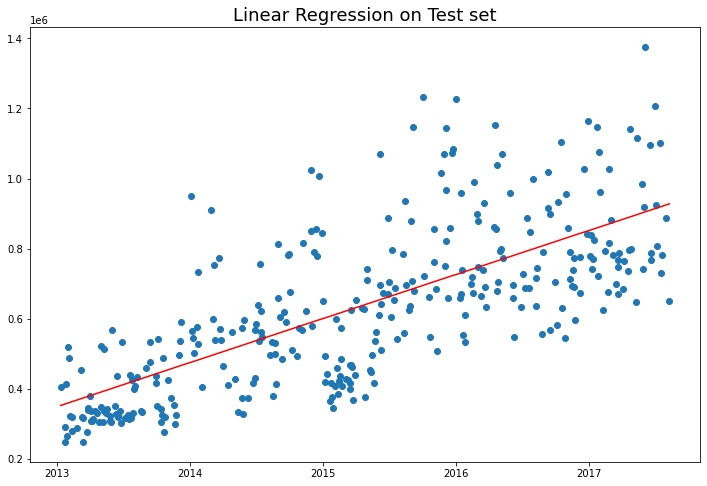

In [10]:
lin_fig = plt.figure(figsize=(12, 8))
plt.scatter(X_test['date'], y_test)
plt.plot(X_test['date'], lin_y_pred, '-', color='r')
plt.title("Linear Regression on Test set", fontsize=18)

In [11]:
# Computing Error
def error(y_pred):
    pred_log = np.array([math.log(i+1) for i in y_pred])
    act_log = np.array([math.log(i+1) for i in y_test])
    dum_error = sum((pred_log - act_log)**2)/len(pred_log)
    linear_error = np.power(dum_error, 1/2)
    return round(linear_error, 4)

print("Error from Linear Regression is", error(lin_y_pred))

Error from Linear Regression is 0.2458


## Trend

In [45]:
df.head()

,date,sales,onpromotion,time
0,2013-01-01,2511.618999,0,0
1,2013-01-02,496092.417944,0,1
2,2013-01-03,361461.231124,0,2
3,2013-01-04,354459.677093,0,3
4,2013-01-05,477350.121229,0,4


In [52]:
trendSeries = df[['date', 'sales']].set_index("date").to_period("D")
trendSeries.head()

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


In [53]:
# average with appropriate parameters for trend estimation.
moving_trend = trendSeries.rolling(
    window=365,       # 365-days window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean() 

<AxesSubplot:title={'center':'Store Sales 30-Day Moving Average'}, xlabel='date'>

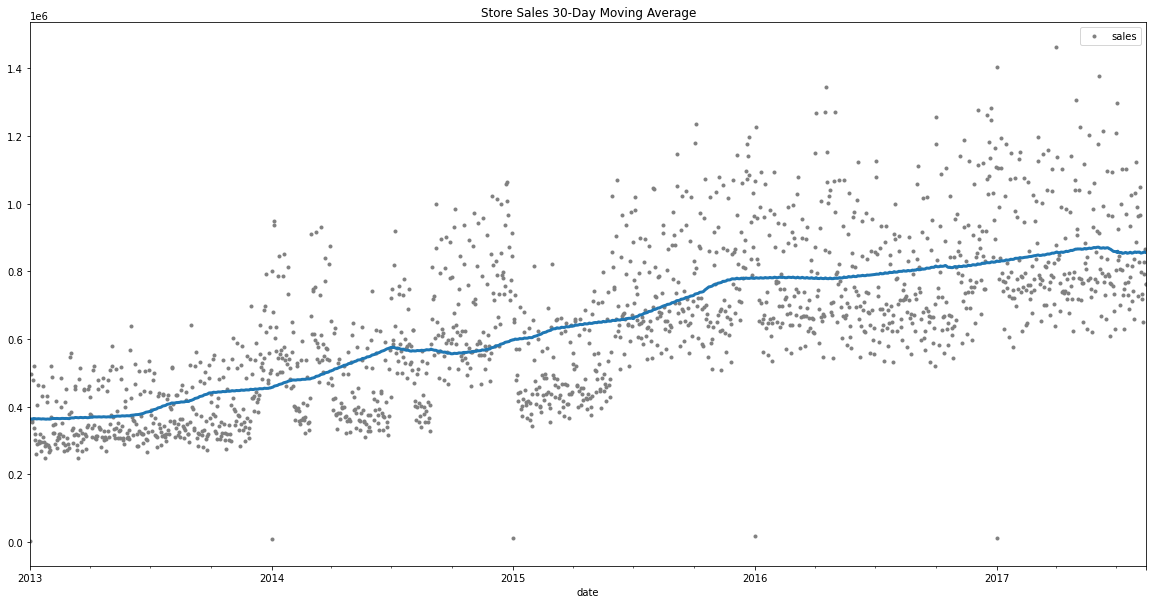

In [54]:
ax = trendSeries.plot(figsize=(20, 10), style=".", color="0.5")
moving_trend.plot(
    ax=ax, linewidth=3, title="Store Sales 30-Day Moving Average", legend=False,
)

In [2]:
print("UPdated?")

UPdated?
